In [38]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import scienceplots

import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
import numpy as np
from scipy.integrate import simps
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

In [39]:
#reading in data with relative paths so that it can be used by others who clone repository from github
script_dir = os.getcwd()

# the baseline were useing for treeplanting scenatio is all grass and its been extended 5km 
allforest_7m= os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'sensitivity_analysis', 'july_allforest_widen20_7mtree'))
allforest_9m = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'sensitivity_analysis', 'july_allforest_widen20_9mtree'))
allforest_11m = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'sensitivity_analysis', 'july_allforest_widen20_11mtree'))

#Temperature Observations folder
observed_temp_path = os.path.abspath(os.path.join(script_dir, 'observations', 'TemperatureDataObs'))
#Temperature observations
obs = pd.read_csv(os.path.join(observed_temp_path, 'HourlySummer23Master_riverkm.csv'))

In [40]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(allforest_7m, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
#obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

### Plotting temperature profiles from the all grass baselines with varying width changes

In [41]:
### Get temps from 10m buffer simulation ###
allforest_7m_folder = os.path.abspath(os.path.join(allforest_7m))
allforest_7m = pd.read_csv(os.path.join(allforest_7m_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 187))
allforest_7m.columns = [float(col) for col in allforest_7m.columns]
allforest_7m.index = obs_clip.index
# mean july temperature summary
mean_7m = allforest_7m.resample('D').mean()
mean_7m = mean_7m.mean()    
mean_7m = pd.DataFrame(mean_7m)
mean_7m = mean_7m.reset_index()
mean_7m.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

In [42]:
allforest_7m

,18.5,18.4,18.3,18.2,18.1,18.0,17.9,17.8,17.7,17.6,...,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.0
datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-01 00:00:00,20.817,20.8082,20.8125,20.8106,20.8066,20.8100,20.8093,20.7533,20.8100,20.8108,...,20.8145,20.8146,20.8151,20.8128,20.8128,20.8140,20.8130,20.8082,20.8126,20.8133
2023-07-01 01:00:00,20.484,20.4642,20.4736,20.4690,20.4530,20.4499,20.3883,19.7376,19.7847,19.8130,...,20.4598,20.4919,20.5229,20.5352,20.5476,20.5614,20.5674,20.5572,20.5637,20.5688
2023-07-01 02:00:00,20.150,20.1411,20.1581,20.1634,20.1584,20.1606,20.1061,19.4601,19.4942,19.5080,...,20.0966,20.1280,20.1591,20.1780,20.1957,20.2135,20.2248,20.2224,20.2342,20.2457
2023-07-01 03:00:00,19.841,19.8350,19.8528,19.8610,19.8612,19.8650,19.8153,19.1795,19.2132,19.2246,...,19.7992,19.8237,19.8486,19.8664,19.8821,19.8976,19.9071,19.9050,19.9157,19.9271
2023-07-01 04:00:00,19.484,19.4891,19.5151,19.5323,19.5431,19.5514,19.5110,18.8889,18.9258,18.9378,...,19.5628,19.5807,19.5993,19.6137,19.6255,19.6368,19.6425,19.6377,19.6454,19.6542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31 19:00:00,24.171,24.0641,24.0407,23.9584,23.8705,23.8355,23.6909,22.7350,22.6951,22.6560,...,20.9584,21.0003,21.0401,21.0777,21.1153,21.1420,21.1610,21.1637,21.1803,21.2003
2023-07-31 20:00:00,23.232,23.2080,23.2514,23.2380,23.2106,23.2160,23.1336,22.2511,22.2626,22.2563,...,20.5593,20.5926,20.6254,20.6533,20.6785,20.7005,20.7156,20.7171,20.7318,20.7492
2023-07-31 21:00:00,22.202,22.2191,22.2914,22.3128,22.3184,22.3461,22.3057,21.5167,21.5689,21.5896,...,20.2176,20.2354,20.2546,20.2685,20.2810,20.2934,20.2998,20.2938,20.3022,20.3122


In [43]:
### Get temps from 40% narrowing simulation ###
allforest_9m_folder = os.path.abspath(os.path.join(allforest_9m))
allforest_9m = pd.read_csv(os.path.join(allforest_9m_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 187))
allforest_9m.columns = [float(col) for col in allforest_9m.columns]
allforest_9m.index = obs_clip.index
# mean july temperature summary
mean_9m = allforest_9m.resample('D').mean()
mean_9m = mean_9m.mean()    
mean_9m = pd.DataFrame(mean_9m)
mean_9m = mean_9m.reset_index()
mean_9m.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

In [44]:
### Get temps from 20% narrowing simulation ###
allforest_11m_folder = os.path.abspath(os.path.join(allforest_11m))
allforest_11m = pd.read_csv(os.path.join(allforest_11m_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 187))
allforest_11m.columns = [float(col) for col in allforest_11m.columns]
allforest_11m.index = obs_clip.index
# mean july temperature summary
mean_11m = allforest_11m.resample('D').mean()
mean_11m = mean_11m.mean()    
mean_11m = pd.DataFrame(mean_11m)
mean_11m = mean_11m.reset_index()
mean_11m.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

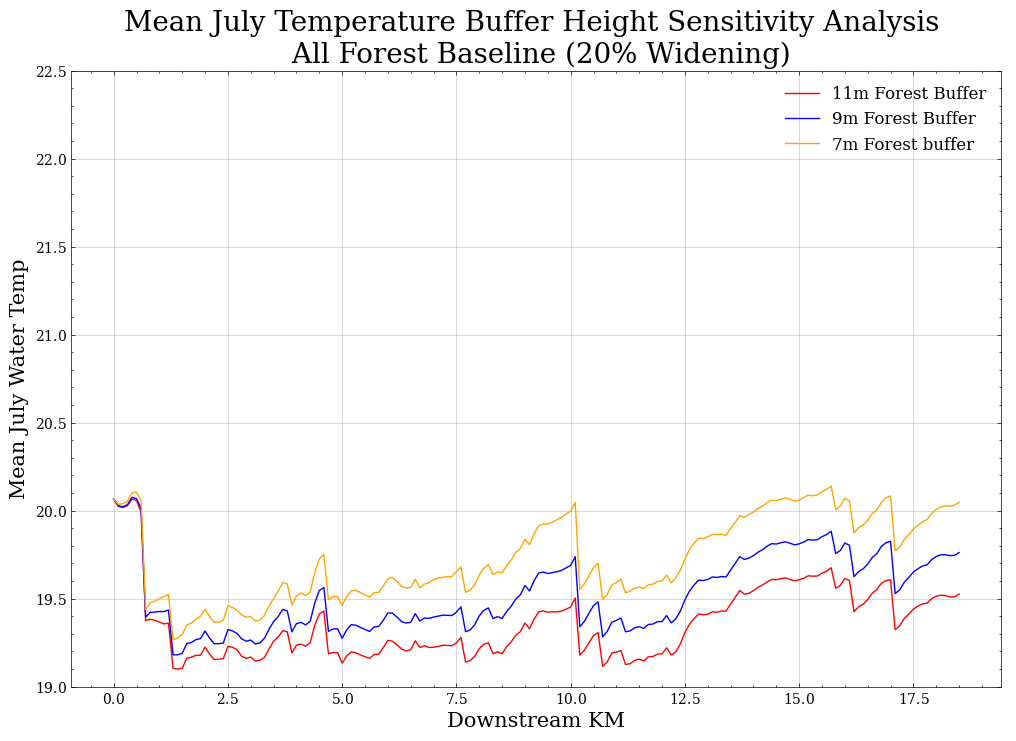

In [54]:
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize = (12,8))

    #plt.fill_between([23.5 - km_start, 23.5 - km_end], upstreamconstant_modeled['Mean July Temp'].min(),upstreamconstant_modeled['Mean July Temp'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
    plt.plot(18.5-mean_11m['NODE_ID'], mean_11m['Mean July Temp'], label=f'11m Forest Buffer', color = 'red')
    plt.plot(18.5-mean_9m['NODE_ID'], mean_9m['Mean July Temp'], label=f'9m Forest Buffer', color = 'blue')
    plt.plot(18.5-mean_7m['NODE_ID'], mean_7m['Mean July Temp'], label=f'7m Forest buffer', color = 'orange')


    #plt.plot(23.5-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Mean July Temp'], label='Base Model')
    #plt.set_title(f'Max July MWAT - Shade added between {23.5 - km_start} km and {23.5 - km_end} km')
    plt.title(f'Mean July Temperature Buffer Height Sensitivity Analysis \n All Forest Baseline (20% Widening)', fontsize = 20)

    plt.xlabel('Downstream KM', fontsize = 15)  # Replace 'X Label' with appropriate label
    plt.ylabel('Mean July Water Temp (${^\circ}C$)', fontsize = 15)  # Replace Y Label with appropriate label
    #plt.text(0.75, 0.1, f'Area Between Curves = {round(area,2)}', horizontalalignment='center', transform=plt.transAxes)

    # Plot the shade data on the second y-axis
    # plt = plt.twinx()
    # plt.plot(23.5-shade.index, shade[0], label='Mean Solar Radiation Flux \n At Stream Surface', color='red', alpha = .5)
    # plt.set_ylabel('Mean Solar Radiation Flux \n At Stream Surface (W/m2)', color = 'red')
    # plt.tick_params(axis='y', colors='red')

    #plt.vlines([23.5 - km_start, 23.5 - km_end], ymin = upstreamconstant_modeled['Max MWAT'].min(), ymax = upstreamconstant_modeled['Max MWAT'].max(),color = 'orange', linestyles = 'dashed')
    plt.grid(True, alpha = .7) 
    plt.ylim(19,22.5)

    plt.legend(loc = 'upper right', fontsize = 12)
plt.savefig(os.path.join(script_dir, 'Figures', 'ForestBufferheightSensitivity_731.png'), bbox_inches='tight', dpi=300)



### Plotting temperature profiles from the all forest baselines with varying width changes

In [46]:
### Get temps from 40% widening simulation ###
widen40__folder = os.path.abspath(os.path.join(widen40_source_folder))
widen40_tw_df = pd.read_csv(os.path.join(widen40_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=11, usecols=range(1, 237))
widen40_tw_df.columns = [float(col) for col in widen40_tw_df.columns]
widen40_tw_df.index = obs_clip.index
# mean july temperature summary
mean_widen40 = widen40_tw_df.resample('D').mean()
mean_widen40 = mean_widen40.mean()    
mean_widen40 = pd.DataFrame(mean_widen40)
mean_widen40 = mean_widen40.reset_index()
mean_widen40.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

NameError: name 'widen40_source_folder' is not defined

In [ ]:
### Get temps from 40% widening simulation ###
widen30__folder = os.path.abspath(os.path.join(widen30_source_folder))
widen30_tw_df = pd.read_csv(os.path.join(widen30__folder, 'outputs', 'Temp_H2O.csv'), skiprows=11, usecols=range(1, 237))
widen30_tw_df.columns = [float(col) for col in widen30_tw_df.columns]
widen30_tw_df.index = obs_clip.index
# mean july temperature summary
mean_widen30 = widen30_tw_df.resample('D').mean()
mean_widen30 = mean_widen30.mean()    
mean_widen30 = pd.DataFrame(mean_widen30)
mean_widen30 = mean_widen30.reset_index()
mean_widen30.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

In [ ]:
### Get temps from 20% narrowing simulation ###
narrow20__folder = os.path.abspath(os.path.join(narrow20_source_folder))
narrow20_tw_df = pd.read_csv(os.path.join(narrow20__folder, 'outputs', 'Temp_H2O.csv'), skiprows=11, usecols=range(1, 237))
narrow20_tw_df.columns = [float(col) for col in narrow20_tw_df.columns]
narrow20_tw_df.index = obs_clip.index
# mean july temperature summary
mean_narrow20 = narrow20_tw_df.resample('D').mean()
mean_narrow20 = mean_narrow20.mean()    
mean_narrow20 = pd.DataFrame(mean_narrow20)
mean_narrow20 = mean_narrow20.reset_index()
mean_narrow20.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)